In [21]:
import os
import numpy as np
import jax.numpy as jnp
import jax.random as random
from scipy.stats import gaussian_kde
# from rsnl.metrics import plot_and_save_coverage
from rsnl.examples.contaminated_normal import assumed_dgp, calculate_summary_statistics, true_dgp
import matplotlib.pyplot as plt
import pickle as pkl
import arviz as az
import matplotlib.colors as mcolors

/Users/ryankelly/python_projects/rsnl/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# check x_obs for seed_9
seed = 9
rng_key = random.PRNGKey(seed)
rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
true_params = jnp.array([1.0])
# true_params = prior.sample(sub_key1)
x_obs = calculate_summary_statistics(true_dgp(sub_key2, true_params))
print('x_obs: ', x_obs)

x_obs:  [1.0420257 2.2400992]


## Model param posterior plot

In [23]:
with open("../res/contaminated_normal/rsnl/seed_9/thetas.pkl", "rb") as f:
    theta_draws_rsnl = jnp.array(pkl.load(f))

thetas_rsnl = jnp.concatenate(theta_draws_rsnl, axis=0)
thetas_rsnl = jnp.squeeze(thetas_rsnl)

with open("../res/contaminated_normal/snl/seed_9/thetas.pkl", "rb") as f:
    theta_draws_snl = jnp.array(pkl.load(f))

thetas_snl = jnp.concatenate(theta_draws_snl, axis=0)
thetas_snl = jnp.squeeze(thetas_snl)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [ ]:
thetas_rsnl

In [ ]:
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 25

az.plot_dist(thetas_rsnl, label="RSNL")

az.plot_dist(thetas_snl,
        color=mcolors.CSS4_COLORS['darkorange'],
        plot_kwargs={'linestyle': 'dashed'},
        label="SNL")

plt.xlabel(r"$\theta$", fontsize=25)
plt.xlim([-1, 3])
plt.ylim(bottom=0)
plt.legend(fontsize=25, borderpad=0.1, labelspacing=0.1, handletextpad=0.1)
plt.ylabel("Density", fontsize=30)
plt.axvline(x=1, color='red', linestyle='dashed')
# plt.title("$b_0 = 0.01$")
plt.tight_layout()
plt.savefig('contaminated_normal_posterior.pdf', bbox_inches='tight')

## Adjustment param posterior plot

In [ ]:
with open("../res/contaminated_normal/rsnl/seed_9/adj_params.pkl", "rb") as f:
    adj_params = jnp.array(pkl.load(f))

adj_params = jnp.concatenate(adj_params, axis=0)


In [ ]:
# plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 25})

rng_key = random.PRNGKey(0)
prior_samples = random.laplace(rng_key, shape=(10000, 2))

for i in range(2):
    az.plot_dist(adj_params[:, i],
                 label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i],
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')
    plt.xlabel(f"$\gamma_{i+1}$", fontsize=25)
    plt.ylabel("Density", fontsize=25)
    plt.xlim([-10, 10])
    plt.ylim(bottom=0)
    plt.xticks(fontsize=25)
    plt.legend(fontsize=25,
               loc='upper left',
               borderpad=0.1, labelspacing=0.1, handletextpad=0.1)

    plt.tight_layout()
    plt.savefig(f'contaminated_normal_adj_param_{i+1}.pdf', bbox_inches='tight')
    plt.clf()

## Posterior Predictive Checks

In [ ]:
# RSNL PPC
x_rsnl_ppc = np.zeros((40000, 2))
theta_draws_rsnl = np.concatenate(theta_draws_rsnl, axis=0)
for ii, theta_rsnl in enumerate(theta_draws_rsnl):
    if ii % 1000 == 0:
        print('ii: ', ii)
    rng_key, sub_key = random.split(rng_key)
    x_rsnl_ppc[ii, :] = calculate_summary_statistics(assumed_dgp(sub_key, theta_rsnl))


In [ ]:
from scipy.stats import gaussian_kde

summ_labels = ['Sample mean', 'Sample variance']
for i in range(2):
    xs = np.linspace(min(x_rsnl_ppc[:, i]),
                     max(x_rsnl_ppc[:, i]), 200)
    kde = gaussian_kde(x_rsnl_ppc[:, i])
    plt.plot(xs, kde(xs), label='Posterior')
    # plt.hist(x_rsnl_ppc[:, i], bins=50)
    plt.axvline(x=x_obs[i], color='red', linestyle='dashed')
    plt.xlabel(summ_labels[i])
    plt.ylabel("Density")
    plt.ylim(bottom=0)
    plt.xticks(fontsize=25)
    plt.savefig(f'contaminated_normal_rsnl_ppc_{i+1}.pdf', bbox_inches='tight')
    plt.clf()

In [ ]:
# SNL PPC
x_snl_ppc = np.zeros((40000, 2))
theta_draws_snl = np.concatenate(theta_draws_snl, axis=0)
for ii, theta_snl in enumerate(theta_draws_snl):
    if ii % 1000 == 0:
        print('ii: ', ii)
    rng_key, sub_key = random.split(rng_key)
    x_snl_ppc[ii, :] = calculate_summary_statistics(assumed_dgp(sub_key, theta_snl))


In [ ]:
# from scipy.stats import gaussian_kde

# summ_labels = ['Sample mean', 'Sample variance']
for i in range(2):
    xs = np.linspace(min(x_snl_ppc[:, i]),
                     max(x_snl_ppc[:, i]), 200)
    kde = gaussian_kde(x_snl_ppc[:, i])
    plt.plot(xs, kde(xs), color='orange',
             label='Posterior')
    # plt.hist(x_rsnl_ppc[:, i], bins=50)
    plt.axvline(x=x_obs[i], color='red', linestyle='dashed')
    plt.xlabel(summ_labels[i])
    plt.ylabel("Density")
    plt.ylim(bottom=0)
    plt.xticks(fontsize=25)
    plt.savefig(f'contaminated_normal_snl_ppc_{i+1}.pdf', bbox_inches='tight')
    plt.clf()

In [ ]:
import pickle as pkl

with open('../res/contaminated_normal/rsnl/v4_seed_0/thetas.pkl', 'rb') as f:
    theta_draws_v4 = jnp.array(pkl.load(f))

theta_draws_v4 = jnp.concatenate(theta_draws_v4, axis=0)
theta_draws_v4 = jnp.squeeze(theta_draws_v4)
# comparison between laplace(0, 0.5) and data-driven prior
with open('../res/contaminated_normal/rsnl/laplace05_v4_seed_0/thetas.pkl', 'rb') as f:
    theta_draws_laplace05_v4 = jnp.array(pkl.load(f))

theta_draws_laplace05_v4 = jnp.concatenate(theta_draws_laplace05_v4, axis=0)
theta_draws_laplace05_v4 = jnp.squeeze(theta_draws_laplace05_v4)


In [ ]:
theta_draws_v4.shape

(40000, 1)

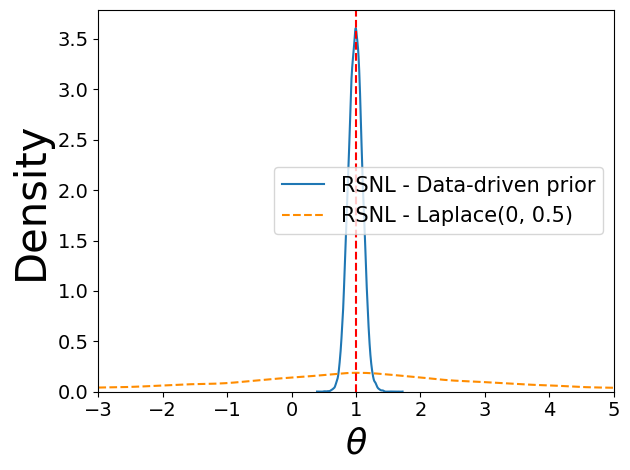

In [28]:
import arviz as az
import matplotlib.colors as mcolors

az.plot_dist(theta_draws_v4, label="RSNL - Data-driven prior")

az.plot_dist(theta_draws_laplace05_v4,
        color=mcolors.CSS4_COLORS['darkorange'],
        plot_kwargs={'linestyle': 'dashed'},
        label="RSNL - Laplace(0, 0.5)")

plt.xlabel(r"$\theta$", fontsize=25)
plt.xlim([-3, 5])
plt.ylim(bottom=0)
plt.legend(fontsize=15)#, borderpad=0.1, labelspacing=0.1, handletextpad=0.1)
plt.ylabel("Density", fontsize=30)
plt.axvline(x=1, color='red', linestyle='dashed')
# plt.title("$b_0 = 0.01$")
plt.tight_layout()
plt.savefig('contaminated_normal_posterior_prior_comparison.pdf', bbox_inches='tight')